# Analiza danych z czujników Samsung - Klasteryzacja

Analiza obejmuje preprocessing, klasteryzację, wizualizację, ocenę jakości klastrów oraz klasyfikację.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Wczytanie i połączenie danych

In [24]:
X_train = pd.read_csv("samsung_HAR/samsung_train.txt", delim_whitespace=True, header=None)
X_test = pd.read_csv("samsung_HAR/samsung_test.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv("samsung_HAR/samsung_train_labels.txt", header=None)
y_test = pd.read_csv("samsung_HAR/samsung_test_labels.txt", header=None)

X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
y.columns = ["Activity"]

y_train.head()

C:\Users\kkleps\AppData\Local\Temp\ipykernel_20732\1365757084.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv("samsung_HAR/samsung_train.txt", delim_whitespace=True, header=None)
C:\Users\kkleps\AppData\Local\Temp\ipykernel_20732\1365757084.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv("samsung_HAR/samsung_test.txt", delim_whitespace=True, header=None)


,0
0,5
1,5
2,5
3,5
4,5


## Skalowanie i PCA

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## Klasteryzacja

In [36]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

agglo = AgglomerativeClustering(n_clusters=6)
agglo_labels = agglo.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)


## Wizualizacja klastrów

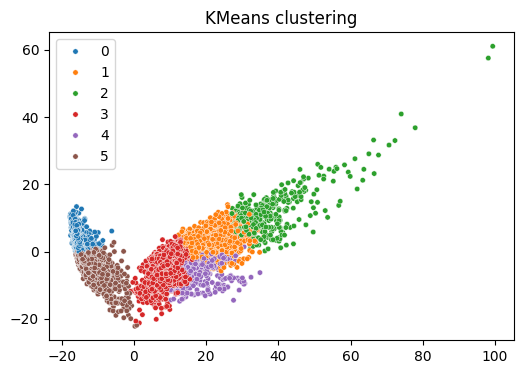

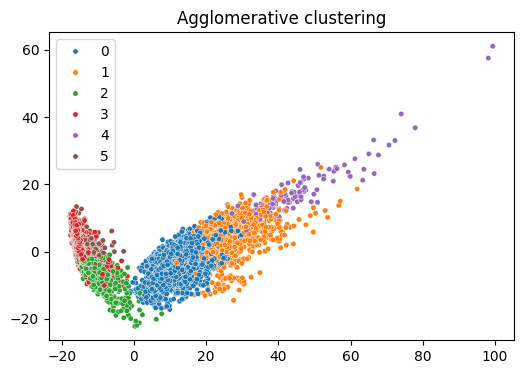

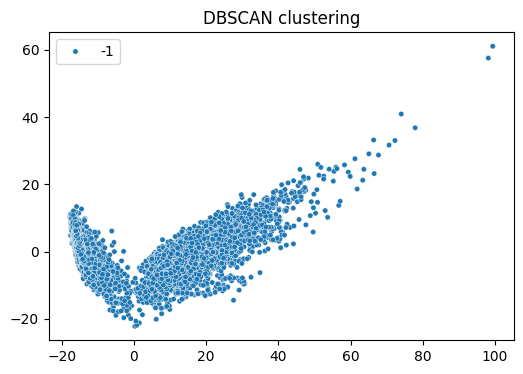

In [ ]:
def plot_clusters(X, labels, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette="tab10", legend="full", s=15)
    plt.title(title)
    plt.show()

plot_clusters(X_pca, kmeans_labels, "KMeans clustering")
plot_clusters(X_pca, agglo_labels, "Agglomerative clustering")      #klasy się mocno przenikają
plot_clusters(X_pca, dbscan_labels, "DBSCAN clustering")            #niezależnie od parametrów zrwaca tylkos szum, jak 

## Ocena jakości klasteryzacji

In [38]:
print("Silhouette KMeans:", silhouette_score(X_scaled, kmeans_labels))
print("Silhouette Agglomerative:", silhouette_score(X_scaled, agglo_labels))
#print("Silhouette DBSCAN:", silhouette_score(X_scaled, dbscan_labels))

Silhouette KMeans: 0.11706978147952804
Silhouette Agglomerative: 0.1170292796580654


## Macierze pomyłek

In [39]:
def evaluate_clustering(true_labels, cluster_labels, name):
    cm = confusion_matrix(true_labels, cluster_labels)
    print(f"\nMacierz pomyłek dla {name}:\n", cm)

evaluate_clustering(y, kmeans_labels, "KMeans")
evaluate_clustering(y, agglo_labels, "Agglomerative")
evaluate_clustering(y, dbscan_labels, "DBSCAN")


Macierz pomyłek dla KMeans:
 [[   0    0    0    0    0    0    0]
 [   0  726   99  810   87    0    0]
 [   0  141   10 1031  362    0    0]
 [   0  868  227  294   17    0    0]
 [1100    0    0    3    0  674    0]
 [ 917    0    0    0    0  989    0]
 [1360    0    0   12    0  572    0]]

Macierz pomyłek dla Agglomerative:
 [[   0    0    0    0    0    0    0]
 [1339  355    0    0   28    0    0]
 [1332  212    0    0    0    0    0]
 [ 537  746    0    0  123    0    0]
 [   0    0  529   22    0 1226    0]
 [   0    0  618    6    0 1282    0]
 [   0    0   59 1806    0   79    0]]

Macierz pomyłek dla DBSCAN:
 [[   0    0    0    0    0    0    0]
 [1722    0    0    0    0    0    0]
 [1544    0    0    0    0    0    0]
 [1406    0    0    0    0    0    0]
 [1777    0    0    0    0    0    0]
 [1906    0    0    0    0    0    0]
 [1944    0    0    0    0    0    0]]


## Metoda łokcia (dobór liczby klastrów)

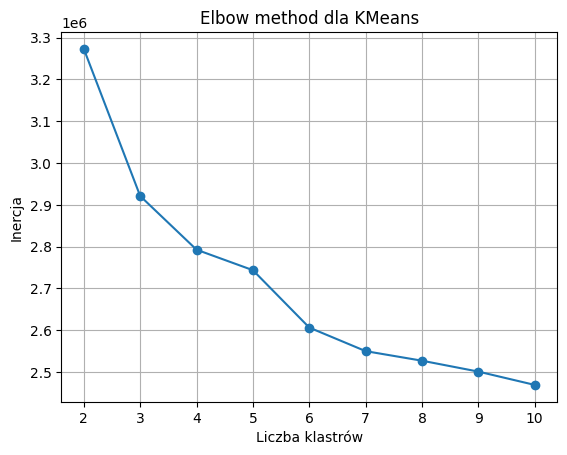

In [40]:
inertia = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow method dla KMeans")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inercja")
plt.grid()
plt.show()

## Dodanie klastra jako cechy i klasyfikacja

In [42]:
# Dodaj etykiety klastrów do danych
X_clustered = X.copy()
X_clustered['Cluster'] = kmeans_labels

# Podział na zbiór treningowy i testowy
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clustered, y, test_size=0.3, random_state=42, stratify=y)

# Rzutowanie nazw kolumn na stringi, żeby uniknąć błędu sklearn
X_train_clf.columns = X_train_clf.columns.astype(str)
X_test_clf.columns = X_test_clf.columns.astype(str)

# Skalowanie
scaler2 = StandardScaler()
X_train_clf_scaled = scaler2.fit_transform(X_train_clf)
X_test_clf_scaled = scaler2.transform(X_test_clf)

In [43]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_clf_scaled, y_train_clf.values.ravel())
print("\nRandom Forest Accuracy:", rf.score(X_test_clf_scaled, y_test_clf))

svc = SVC()
svc.fit(X_train_clf_scaled, y_train_clf.values.ravel())
print("SVM Accuracy:", svc.score(X_test_clf_scaled, y_test_clf))


Random Forest Accuracy: 0.9766990291262136
SVM Accuracy: 0.9754045307443365
